In [37]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, RepeatedKFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import xgboost as xgb
import time

In [38]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [39]:
train = pd.read_csv('train.csv')

In [40]:
test = pd.read_csv('test.csv')

In [41]:
train.head()

,row_id,scout_id,rating_num,winner,team,competitionId,player_position_1,player_position_2,player_height,player_weight,...,team2_defensive_derived_var_10,team2_offensive_derived_var_11,team2_offensive_derived_var_12,team2_offensive_derived_var_13,team2_offensive_derived_var_14,team2_defensive_derived_var_15,team2_offensive_derived_var_16,team2_defensive_derived_var_17,team2_offensive_derived_var_18,team2_offensive_derived_var_19
0,1,13,7.0,winner,team1,8,7.0,7.0,0.317073,0.48,...,0.193658,0.131548,0.097131,0.600944,0.338892,0.347980,0.034157,0.288962,0.310727,0.204925
1,3,16,6.5,loser,team2,8,3.0,9.0,0.463415,0.42,...,0.190500,0.173697,0.272801,0.605659,0.526761,0.468976,0.054034,0.334962,0.380073,0.295392
2,4,4,8.5,loser,team1,5,11.0,11.0,0.682927,0.44,...,0.312314,0.250756,0.212631,0.558833,0.686523,0.441749,0.219441,0.414288,0.570757,0.437500
3,5,13,8.0,loser,team2,4,17.0,17.0,0.682927,0.58,...,0.282556,0.155969,0.206503,0.533002,0.373959,0.527733,0.095201,0.423040,0.330754,0.235558
4,7,11,3.5,draw,team1,5,10.0,10.0,0.731707,0.70,...,0.450453,0.199050,0.134002,0.688773,0.681724,0.733625,0.128719,0.448360,0.444946,0.312500


In [42]:
train_1 = train[['row_id', 'scout_id', 'winner', 'team', 'competitionId', 'player_position_1', 'player_position_2', 'player_height', 'player_weight', 'rating_num']]
train.drop(columns=['row_id', 'scout_id', 'winner', 'team', 'competitionId', 'player_position_1', 'player_position_2', 'player_height', 'player_weight', 'rating_num'], inplace=True)

In [43]:
sys_id = train[['team1_system_id', 'team2_system_id']]
train.drop(columns=['team1_system_id', 'team2_system_id'], inplace=True)

In [44]:
plyr_cols = train.columns.str.contains('player')
plyr_cols = np.flatnonzero(plyr_cols)
player = train.iloc[:,plyr_cols]

team1_cols = train.columns.str.contains('team1')
team1_cols = np.flatnonzero(team1_cols)
team1 = train.iloc[:,team1_cols]

team2_cols = train.columns.str.contains('team2')
team2_cols = np.flatnonzero(team2_cols)
team2 = train.iloc[:,team2_cols]

In [45]:
plyr_attr = np.array(['offensive', 'defensive', 'positional', 'physical', 'general', 'other'])
team_attr = np.array(['offensive', 'defensive', 'other'])
var_type = np.array(['derived', 'raw', 'ratio'])
player_dfs = []
team1_dfs = []
team2_dfs = []

for strs in plyr_attr:
    for vstrs in var_type:
        in_str_arr = 'plyr_'+strs+'_'+vstrs
        in_str_df = 'player_'+strs+'_'+vstrs
        player_dfs.append(in_str_df)
        globals()[in_str_arr] = player.columns.str.contains(strs+'_'+vstrs)
        globals()[in_str_arr] = np.flatnonzero(globals()[in_str_arr])
        globals()[in_str_df] = player.iloc[:, globals()[in_str_arr]]
     
    
for strs in team_attr:
    for vstrs in var_type:
        in_str_arr = 'tm1_'+strs+'_'+vstrs
        in_str_df = 'team1_'+strs+'_'+vstrs
        team1_dfs.append(in_str_df)
        globals()[in_str_arr] = team1.columns.str.contains(strs+'_'+vstrs)
        globals()[in_str_arr] = np.flatnonzero(globals()[in_str_arr])
        globals()[in_str_df] = team1.iloc[:, globals()[in_str_arr]] 
    
for strs in team_attr:
    for vstrs in var_type:
        in_str_arr = 'tm2_'+strs+'_'+vstrs
        in_str_df = 'team2_'+strs+'_'+vstrs
        team2_dfs.append(in_str_df)
        globals()[in_str_arr] = team2.columns.str.contains(strs+'_'+vstrs)
        globals()[in_str_arr] = np.flatnonzero(globals()[in_str_arr])
        globals()[in_str_df] = team2.iloc[:, globals()[in_str_arr]] 

player_dfs = np.array(player_dfs)
team1_dfs = np.array(team1_dfs)
team2_dfs = np.array(team2_dfs)

In [46]:
x = 500
for i in range(len(player_dfs)):
    for col in globals()[player_dfs[i]].columns:
        if(globals()[player_dfs[i]][col].isnull().sum() < x):
            globals()[player_dfs[i]][col] = globals()[player_dfs[i]][col].fillna(globals()[player_dfs[i]][col].mean())
        else:
            globals()[player_dfs[i]] = globals()[player_dfs[i]].drop(columns=[col], axis=1)

for i in range(len(team1_dfs)):
    for col in globals()[team1_dfs[i]].columns:
        if(globals()[team1_dfs[i]][col].isnull().sum() < x):
            globals()[team1_dfs[i]][col] = globals()[team1_dfs[i]][col].fillna(globals()[team1_dfs[i]][col].mean())
        else:
            globals()[team1_dfs[i]] = globals()[team1_dfs[i]].drop(columns=[col], axis=1)

            
for i in range(len(team2_dfs)):
    for col in globals()[team2_dfs[i]].columns:
        if(globals()[team2_dfs[i]][col].isnull().sum() < x):
            globals()[team2_dfs[i]][col] = globals()[team2_dfs[i]][col].fillna(globals()[team2_dfs[i]][col].mean())
        else:
            globals()[team2_dfs[i]] = globals()[team2_dfs[i]].drop(columns=[col], axis=1)


/tmp/ipykernel_18631/3045033660.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  globals()[player_dfs[i]][col] = globals()[player_dfs[i]][col].fillna(globals()[player_dfs[i]][col].mean())
/tmp/ipykernel_18631/3045033660.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  globals()[player_dfs[i]][col] = globals()[player_dfs[i]][col].fillna(globals()[player_dfs[i]][col].mean())
/tmp/ipykernel_18631/3045033660.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [47]:
print(len(globals()))
indexp = []
indext1 = []
indext2 = []
for i in range(len(player_dfs)):
    if(globals()[player_dfs[i]].shape[1] != 0):
        scaled_features = StandardScaler().fit_transform(globals()[player_dfs[i]].values)
        globals()[player_dfs[i]] = pd.DataFrame(scaled_features, index=globals()[player_dfs[i]].index, columns=globals()[player_dfs[i]].columns)
    else:
        del globals()[player_dfs[i]]
        indexp.append(i)

for i in range(len(team1_dfs)):
    if(globals()[team1_dfs[i]].shape[1] != 0):
        scaled_features = StandardScaler().fit_transform(globals()[team1_dfs[i]].values)
        globals()[team1_dfs[i]] = pd.DataFrame(scaled_features, index=globals()[team1_dfs[i]].index, columns=globals()[team1_dfs[i]].columns)
    else:
        del globals()[team1_dfs[i]]
        indext1.append(i)
        
for i in range(len(team2_dfs)):
    if(globals()[team2_dfs[i]].shape[1] != 0):
        scaled_features = StandardScaler().fit_transform(globals()[team2_dfs[i]].values)
        globals()[team2_dfs[i]] = pd.DataFrame(scaled_features, index=globals()[team2_dfs[i]].index, columns=globals()[team2_dfs[i]].columns)
    else:
        del globals()[team2_dfs[i]]
        indext2.append(i)
        
player_dfs = np.delete(player_dfs, indexp)
team1_dfs = np.delete(team1_dfs, indext1)
team2_dfs = np.delete(team2_dfs, indext2)

283


In [48]:
for i in range(len(player_dfs)):
    if(globals()[player_dfs[i]].shape[1] > 2):
        pca = PCA(n_components=2)
        pca.fit(globals()[player_dfs[i]])
        columns = [player_dfs[i]+'_pca_%i' % j for j in range(2)]
        globals()[player_dfs[i]] = pd.DataFrame(pca.transform(globals()[player_dfs[i]]), columns=columns, index=globals()[player_dfs[i]].index)
        columns.clear()
        
for i in range(len(team1_dfs)):
    if(globals()[team1_dfs[i]].shape[1] > 2):
        pca = PCA(n_components=2)
        pca.fit(globals()[team1_dfs[i]])
        columns = [team1_dfs[i]+'_pca_%i' % j for j in range(2)]
        globals()[team1_dfs[i]] = pd.DataFrame(pca.transform(globals()[team1_dfs[i]]), columns=columns, index=globals()[team1_dfs[i]].index)
        columns.clear()
        
for i in range(len(team2_dfs)):
    if(globals()[team2_dfs[i]].shape[1] > 2):
        pca = PCA(n_components=2)
        pca.fit(globals()[team2_dfs[i]])
        columns = [team2_dfs[i]+'_pca_%i' % j for j in range(2)]
        globals()[team2_dfs[i]] = pd.DataFrame(pca.transform(globals()[team2_dfs[i]]), columns=columns, index=globals()[team2_dfs[i]].index)
        columns.clear()

In [49]:
train_f = pd.concat([train_1.reset_index(drop=True),sys_id.reset_index(drop=True)], axis=1)
for i in range(len(player_dfs)):
    train_f = pd.concat([train_f.reset_index(drop=True),globals()[player_dfs[i]].reset_index(drop=True)], axis=1)

for i in range(len(team1_dfs)):
    train_f = pd.concat([train_f.reset_index(drop=True),globals()[team1_dfs[i]].reset_index(drop=True)], axis=1)

for i in range(len(team2_dfs)):
    train_f = pd.concat([train_f.reset_index(drop=True),globals()[team2_dfs[i]].reset_index(drop=True)], axis=1)


In [50]:
train_f.shape

(20453, 60)

In [51]:
winner = {'winner': 1, 'loser': 0, 'draw':2}
team = {'team1': 1, 'team2': 2}
train_f['winner'] = [winner[item] for item in train_f['winner']]
train_f['team'] = [team[item] for item in train_f['team']]

In [52]:
train_f.head(10)

,row_id,scout_id,winner,team,competitionId,player_position_1,player_position_2,player_height,player_weight,rating_num,...,team2_offensive_derived_var_7,team2_offensive_derived_var_11,team2_offensive_raw_pca_0,team2_offensive_raw_pca_1,team2_defensive_derived_var_2,team2_defensive_derived_var_6,team2_defensive_raw_pca_0,team2_defensive_raw_pca_1,team2_other_raw_pca_0,team2_other_raw_pca_1
0,1,13,1,1,8,7.0,7.0,0.317073,0.48,7.0,...,-0.688569,-0.812261,-0.477161,-0.677116,-0.058388,-0.036285,0.485362,-0.407943,-0.300589,0.107806
1,3,16,0,2,8,3.0,9.0,0.463415,0.42,6.5,...,0.096769,-0.102233,0.701913,-0.342654,1.682615,1.474577,-0.391800,2.138240,0.301026,1.390033
2,4,4,0,1,5,11.0,11.0,0.682927,0.44,8.5,...,1.311101,1.195857,2.816161,0.305678,-0.817088,0.022627,0.485362,-0.407943,0.029089,-1.226413
3,5,13,0,2,4,17.0,17.0,0.682927,0.58,8.0,...,-0.688569,-0.400884,-0.477161,-0.677116,0.660911,-0.770896,-0.477196,-0.766853,0.947034,-1.109580
4,7,11,2,1,5,10.0,10.0,0.731707,0.70,3.5,...,0.241365,0.324841,0.701913,-0.342654,-0.368626,-0.770896,-0.477196,-0.766853,1.006075,-1.069425
5,8,11,2,1,5,10.0,10.0,0.731707,0.70,3.5,...,0.241365,0.324841,0.701913,-0.342654,-0.368626,-0.770896,-0.477196,-0.766853,1.006075,-1.069425
6,9,15,1,2,7,10.0,10.0,0.609756,0.46,7.0,...,-0.688569,0.988217,-0.477161,-0.677116,-0.774788,-0.770896,-0.477196,-0.766853,-0.280196,-0.372526
7,10,4,0,1,7,3.0,9.0,0.243902,0.34,7.5,...,1.497701,-0.055202,-1.747255,3.340755,0.232580,0.148197,-0.915778,0.506238,0.395194,2.106428
8,11,16,1,1,7,8.0,8.0,0.390244,0.22,7.5,...,-0.688569,-0.367046,-0.477161,-0.677116,-0.635616,-0.770896,-0.477196,-0.766853,0.147172,-1.146103
9,12,3,2,2,5,3.0,3.0,0.609756,0.58,6.5,...,-0.688569,-0.071113,-0.477161,-0.677116,-0.649214,-0.770896,-0.477196,-0.766853,0.147172,-1.146103


In [53]:
train_f.columns

Index(['row_id', 'scout_id', 'winner', 'team', 'competitionId',
       'player_position_1', 'player_position_2', 'player_height',
       'player_weight', 'rating_num', 'team1_system_id', 'team2_system_id',
       'player_offensive_derived_pca_0', 'player_offensive_derived_pca_1',
       'player_offensive_raw_pca_0', 'player_offensive_raw_pca_1',
       'player_offensive_ratio_pca_0', 'player_offensive_ratio_pca_1',
       'player_defensive_derived_pca_0', 'player_defensive_derived_pca_1',
       'player_defensive_raw_pca_0', 'player_defensive_raw_pca_1',
       'player_defensive_ratio_pca_0', 'player_defensive_ratio_pca_1',
       'player_positional_derived_pca_0', 'player_positional_derived_pca_1',
       'player_positional_raw_pca_0', 'player_positional_raw_pca_1',
       'player_positional_ratio_var_0', 'player_positional_ratio_var_1',
       'player_general_derived_pca_0', 'player_general_derived_pca_1',
       'player_general_raw_pca_0', 'player_general_raw_pca_1',
       'player_

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'scout_id'),
  Text(1, 0, 'winner'),
  Text(2, 0, 'team'),
  Text(3, 0, 'competitionId'),
  Text(4, 0, 'player_position_1'),
  Text(5, 0, 'player_position_2'),
  Text(6, 0, 'player_height')])

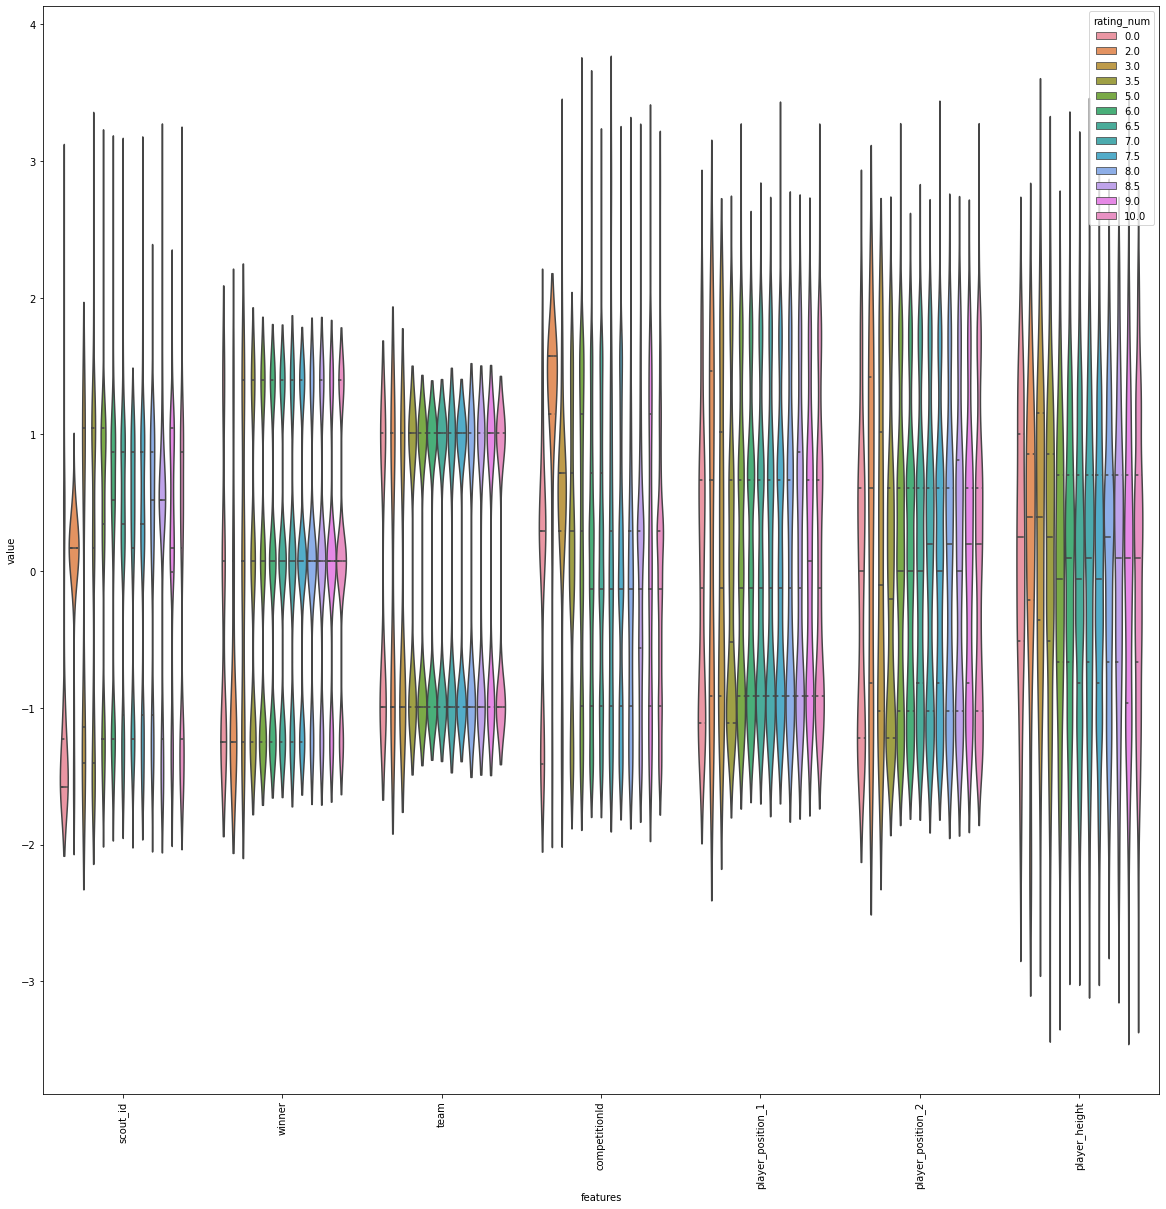

In [59]:
x = train_f[['scout_id', 'winner', 'team', 'competitionId', 'player_position_1', 'player_position_2', 'player_height']]
y = train_f['rating_num']
x_2 = (x - x.mean()) / (x.std())              
x = pd.concat([y,x_2.iloc[:,0:7]],axis=1)
x = pd.melt(x,id_vars="rating_num",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(20,20))
sns.violinplot(x="features", y="value", hue="rating_num", data=x,split=False, inner="quart")
plt.xticks(rotation=90)

/home/tanmay1024/anaconda3/envs/TensorTorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


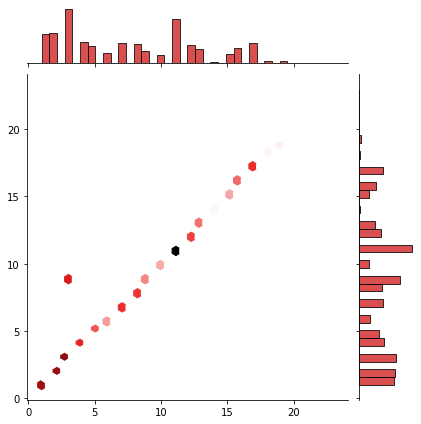

In [73]:
sns.jointplot(np.array(train_f['player_position_1']), np.array(train_f['player_position_2']), kind="hex", color="#ce1414")

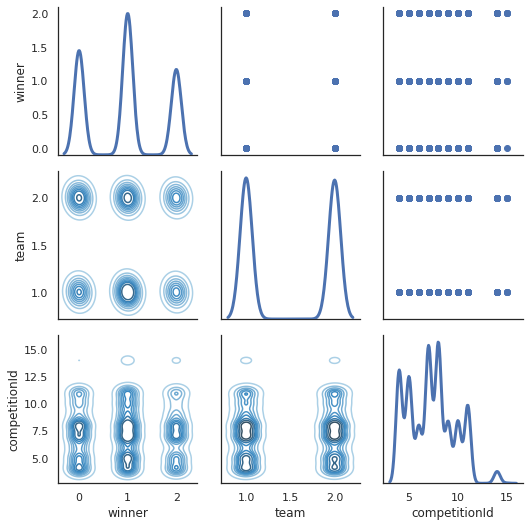

In [74]:
sns.set(style="white")
df = train_f.loc[:,['winner', 'team', 'competitionId']]
g = sns.PairGrid(df, diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

<AxesSubplot:>

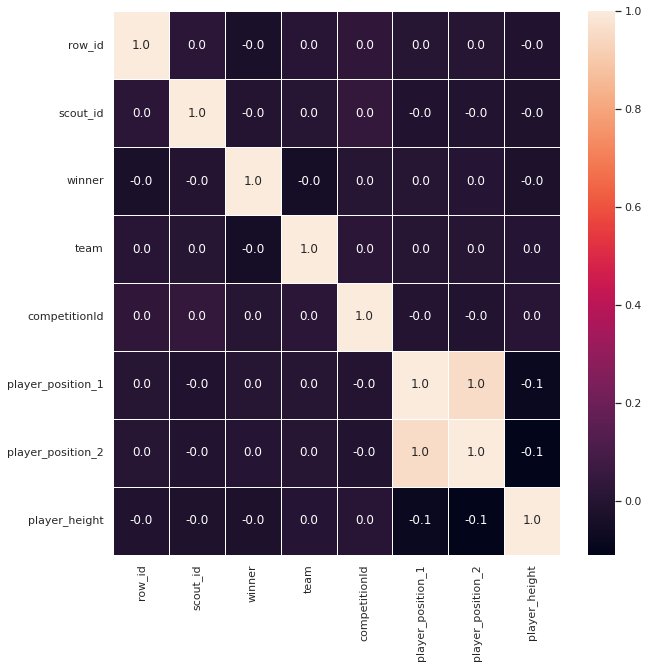

In [77]:
df_1 = train_f.iloc[:,:8]
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df_1.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [17]:
final_train_y = pd.DataFrame(train_f['rating_num'])
train_f.drop(columns=['rating_num'], inplace=True)
final_train_x = train_f

In [18]:
final_train_y.head(10)

,rating_num
0,7.0
1,6.5
2,8.5
3,8.0
4,3.5
5,3.5
6,7.0
7,7.5
8,7.5
9,6.5


In [19]:
final_train_x.head(10)

,row_id,scout_id,winner,team,competitionId,player_position_1,player_position_2,player_height,player_weight,team1_system_id,...,team2_offensive_derived_var_7,team2_offensive_derived_var_11,team2_offensive_raw_pca_0,team2_offensive_raw_pca_1,team2_defensive_derived_var_2,team2_defensive_derived_var_6,team2_defensive_raw_pca_0,team2_defensive_raw_pca_1,team2_other_raw_pca_0,team2_other_raw_pca_1
0,1,13,1,1,8,7.0,7.0,0.317073,0.48,6.0,...,-0.688569,-0.812261,-0.477161,-0.677116,-0.058388,-0.036285,0.485362,-0.407943,-0.300589,0.107806
1,3,16,0,2,8,3.0,9.0,0.463415,0.42,6.0,...,0.096769,-0.102233,0.701913,-0.342654,1.682615,1.474577,-0.391800,2.138240,0.301026,1.390033
2,4,4,0,1,5,11.0,11.0,0.682927,0.44,8.0,...,1.311101,1.195857,2.816161,0.305678,-0.817088,0.022627,0.485362,-0.407943,0.029089,-1.226413
3,5,13,0,2,4,17.0,17.0,0.682927,0.58,6.0,...,-0.688569,-0.400884,-0.477161,-0.677116,0.660911,-0.770896,-0.477196,-0.766853,0.947034,-1.109580
4,7,11,2,1,5,10.0,10.0,0.731707,0.70,12.0,...,0.241365,0.324841,0.701913,-0.342654,-0.368626,-0.770896,-0.477196,-0.766853,1.006075,-1.069425
5,8,11,2,1,5,10.0,10.0,0.731707,0.70,NaN,...,0.241365,0.324841,0.701913,-0.342654,-0.368626,-0.770896,-0.477196,-0.766853,1.006075,-1.069425
6,9,15,1,2,7,10.0,10.0,0.609756,0.46,6.0,...,-0.688569,0.988217,-0.477161,-0.677116,-0.774788,-0.770896,-0.477196,-0.766853,-0.280196,-0.372526
7,10,4,0,1,7,3.0,9.0,0.243902,0.34,10.0,...,1.497701,-0.055202,-1.747255,3.340755,0.232580,0.148197,-0.915778,0.506238,0.395194,2.106428
8,11,16,1,1,7,8.0,8.0,0.390244,0.22,6.0,...,-0.688569,-0.367046,-0.477161,-0.677116,-0.635616,-0.770896,-0.477196,-0.766853,0.147172,-1.146103
9,12,3,2,2,5,3.0,3.0,0.609756,0.58,12.0,...,-0.688569,-0.071113,-0.477161,-0.677116,-0.649214,-0.770896,-0.477196,-0.766853,0.147172,-1.146103


In [21]:
model.fit(final_train_x, final_train_y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, ...)

In [ ]:
# params = {
#     'n_estimators':[500],
#     'min_child_weight':[5], 
#     'gamma':[i/10.0 for i in range(3,6)],  
#     'subsample':[i/10.0 for i in range(6,11)],
#     'colsample_bytree':[i/10.0 for i in range(6,11)], 
#     'max_depth': [6,7],
#     'objective': ['reg:squarederror', 'reg:tweedie'],
#     'booster': ['gbtree', 'gblinear'],
#     'eval_metric': ['r2'],
#     'eta': [i/10.0 for i in range(3,6)],
# }

# n_iter_search = 10
# random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=n_iter_search, cv=5, scoring='r2')

In [ ]:
# start = time.time()
# random_search.fit(final_train_x, final_train_y)
# print("RandomizedSearchCV took %.2f seconds for %d candidates"
#       " parameter settings." % ((time.time() - start), n_iter_search))

In [24]:
globals()[team1_dfs[4]].isnull().sum()

team1_other_raw_pca_0    0
team1_other_raw_pca_1    0
dtype: int64

In [ ]:
test_1 = test[['row_id', 'scout_id', 'winner', 'team', 'competitionId', 'player_position_1', 'player_position_2', 'player_height', 'player_weight']]
test.drop(columns=['row_id', 'scout_id', 'winner', 'team', 'competitionId', 'player_position_1', 'player_position_2', 'player_height', 'player_weight'], inplace=True)
t_sys_id = test[['team1_system_id', 'team2_system_id']]
test.drop(columns=['team1_system_id', 'team2_system_id'], inplace=True)


t_plyr_cols = test.columns.str.contains('player')
t_plyr_cols = np.flatnonzero(t_plyr_cols)
t_player = test.iloc[:,t_plyr_cols]

t_team1_cols = test.columns.str.contains('team1')
t_team1_cols = np.flatnonzero(t_team1_cols)
t_team1 = test.iloc[:,t_team1_cols]

t_team2_cols = test.columns.str.contains('team2')
t_team2_cols = np.flatnonzero(t_team2_cols)
t_team2 = test.iloc[:,t_team2_cols]


t_plyr_attr = np.array(['offensive', 'defensive', 'positional', 'physical', 'general', 'other'])
t_team_attr = np.array(['offensive', 'defensive', 'other'])
t_var_type = np.array(['derived', 'raw', 'ratio'])
t_player_dfs = []
t_team1_dfs = []
t_team2_dfs = []

for strs in t_plyr_attr:
    for vstrs in t_var_type:
        t_in_str_arr = 't_plyr_'+strs+'_'+vstrs
        t_in_str_df = 't_player_'+strs+'_'+vstrs
        t_player_dfs.append(t_in_str_df)
        globals()[t_in_str_arr] = t_player.columns.str.contains(strs+'_'+vstrs)
        globals()[t_in_str_arr] = np.flatnonzero(globals()[t_in_str_arr])
        globals()[t_in_str_df] = t_player.iloc[:, globals()[t_in_str_arr]]
     
    
for strs in t_team_attr:
    for vstrs in t_var_type:
        t_in_str_arr = 't_tm1_'+strs+'_'+vstrs
        t_in_str_df = 't_team1_'+strs+'_'+vstrs
        t_team1_dfs.append(t_in_str_df)
        globals()[t_in_str_arr] = t_team1.columns.str.contains(strs+'_'+vstrs)
        globals()[t_in_str_arr] = np.flatnonzero(globals()[t_in_str_arr])
        globals()[t_in_str_df] = t_team1.iloc[:, globals()[t_in_str_arr]] 
    
for strs in t_team_attr:
    for vstrs in t_var_type:
        t_in_str_arr = 't_tm2_'+strs+'_'+vstrs
        t_in_str_df = 't_team2_'+strs+'_'+vstrs
        t_team2_dfs.append(t_in_str_df)
        globals()[t_in_str_arr] = t_team2.columns.str.contains(strs+'_'+vstrs)
        globals()[t_in_str_arr] = np.flatnonzero(globals()[t_in_str_arr])
        globals()[t_in_str_df] = t_team2.iloc[:, globals()[t_in_str_arr]] 

t_player_dfs = np.array(t_player_dfs)
t_team1_dfs = np.array(t_team1_dfs)
t_team2_dfs = np.array(t_team2_dfs)
# print(t_player_dfs)

indexp = []
indext1 = []
indext2 = []
x = 500
for i in range(len(t_player_dfs)):
    if(t_player_dfs[i].replace('t_', '') in player_dfs):
        for col in globals()[t_player_dfs[i]].columns:
            if(globals()[t_player_dfs[i]][col].isnull().sum() < x):
                globals()[t_player_dfs[i]][col] = globals()[t_player_dfs[i]][col].fillna(globals()[t_player_dfs[i]][col].mean())
            else:
                globals()[t_player_dfs[i]] = globals()[t_player_dfs[i]].drop(columns=[col])
    else:
        del globals()[t_player_dfs[i]]
        indexp.append(i)
        
for i in range(len(t_team1_dfs)):
    if(t_team1_dfs[i].replace('t_', '') in team1_dfs):
        for col in globals()[t_team1_dfs[i]].columns:
            if(globals()[t_team1_dfs[i]][col].isnull().sum() < x):
                globals()[t_team1_dfs[i]][col] = globals()[t_team1_dfs[i]][col].fillna(globals()[t_team1_dfs[i]][col].mean())
            else:
                globals()[t_team1_dfs[i]] = globals()[t_team1_dfs[i]].drop(columns=[col]) 
    else:
        del globals()[t_team1_dfs[i]]
        indext1.append(i)
        
for i in range(len(t_team2_dfs)):
    if(t_team2_dfs[i].replace('t_', '') in team2_dfs):
        for col in globals()[t_team2_dfs[i]].columns:
            if(globals()[t_team2_dfs[i]][col].isnull().sum() < x):
                globals()[t_team2_dfs[i]][col] = globals()[t_team2_dfs[i]][col].fillna(globals()[t_team2_dfs[i]][col].mean())
            else:
                globals()[t_team2_dfs[i]] = globals()[t_team2_dfs[i]].drop(columns=[col])
    else:
        del globals()[t_team2_dfs[i]]
        indext2.append(i)

t_player_dfs = np.delete(t_player_dfs, indexp)
t_team1_dfs = np.delete(t_team1_dfs, indext1)
t_team2_dfs = np.delete(t_team2_dfs, indext2)      
# print(t_team2_dfs)       
        
    
for i in range(len(t_player_dfs)):
    scaled_features = StandardScaler().fit_transform(globals()[t_player_dfs[i]].values)
    globals()[t_player_dfs[i]] = pd.DataFrame(scaled_features, index=globals()[t_player_dfs[i]].index, columns=globals()[t_player_dfs[i]].columns)
    pca = PCA(n_components=2)
    pca.fit(globals()[t_player_dfs[i]])
    columns = [t_player_dfs[i]+'_pca_%i' % j for j in range(2)]
    globals()[t_player_dfs[i]] = pd.DataFrame(pca.transform(globals()[t_player_dfs[i]]), columns=columns, index=globals()[t_player_dfs[i]].index)
    columns.clear()

for i in range(len(t_team1_dfs)):
    scaled_features = StandardScaler().fit_transform(globals()[t_team1_dfs[i]].values)
    globals()[t_team1_dfs[i]] = pd.DataFrame(scaled_features, index=globals()[t_team1_dfs[i]].index, columns=globals()[t_team1_dfs[i]].columns)
    pca = PCA(n_components=2)
    pca.fit(globals()[t_team1_dfs[i]])
    columns = [t_team1_dfs[i]+'_pca_%i' % j for j in range(2)]
    globals()[t_team1_dfs[i]] = pd.DataFrame(pca.transform(globals()[t_team1_dfs[i]]), columns=columns, index=globals()[t_team1_dfs[i]].index)
    columns.clear()
        
for i in range(len(t_team2_dfs)):
    scaled_features = StandardScaler().fit_transform(globals()[t_team2_dfs[i]].values)
    globals()[t_team2_dfs[i]] = pd.DataFrame(scaled_features, index=globals()[t_team2_dfs[i]].index, columns=globals()[t_team2_dfs[i]].columns)
    pca = PCA(n_components=2)
    pca.fit(globals()[t_team2_dfs[i]])
    columns = [t_team2_dfs[i]+'_pca_%i' % j for j in range(2)]
    globals()[t_team2_dfs[i]] = pd.DataFrame(pca.transform(globals()[t_team2_dfs[i]]), columns=columns, index=globals()[t_team2_dfs[i]].index)
    columns.clear()
        


In [27]:
test_f = pd.concat([test_1.reset_index(drop=True),t_sys_id.reset_index(drop=True)], axis=1)
for i in range(len(t_player_dfs)):
    test_f = pd.concat([test_f.reset_index(drop=True),globals()[t_player_dfs[i]].reset_index(drop=True)], axis=1)

for i in range(len(team1_dfs)):
    test_f = pd.concat([test_f.reset_index(drop=True),globals()[t_team1_dfs[i]].reset_index(drop=True)], axis=1)

for i in range(len(team2_dfs)):
    test_f = pd.concat([test_f.reset_index(drop=True),globals()[t_team2_dfs[i]].reset_index(drop=True)], axis=1)

test_f['team'] = test_f['team'].fillna('team1')
test_f['competitionId'] = test_f['competitionId'].fillna(test_f['competitionId'].median())
test_f['player_position_1'] = test_f['player_position_1'].fillna(test_f['player_position_1'].median())
test_f['player_position_2'] = test_f['player_position_2'].fillna(test_f['player_position_2'].median())
test_f['player_height'] = test_f['player_height'].fillna(test_f['player_height'].mean())
test_f['player_weight'] = test_f['player_weight'].fillna(test_f['player_weight'].mean())
test_f['team1_system_id'] = test_f['team1_system_id'].fillna(value=np.random.randint(4, 29))
test_f['team2_system_id'] = test_f['team2_system_id'].fillna(value=np.random.randint(4, 29))
    
winner = {'winner': 1, 'loser': 0, 'draw':2}
team = {'team1': 1, 'team2': 2}
test_f['winner'] = [winner[item] for item in test_f['winner']]
test_f['team'] = [team[item] for item in test_f['team']]

In [31]:
model = xgb.XGBRegressor(n_estimators=500, max_depth=5, eta=0.1, subsample=0.6, colsample_bytree=0.6, colsample_bylevel=0.8999999999999999)
model.fit(final_train_x, final_train_y)
predictions = model.predict(test_f)

In [29]:
output = pd.DataFrame(test_f['row_id'])
output['rating_num'] = predictions
output.to_csv('pred3.csv', index=False)

In [ ]:
params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}
xgbr = xgb.XGBRegressor(seed = 20)
clf = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='r2',
                         n_iter=25,
                         verbose=1)
clf.fit(final_train_x, final_train_y)
print("Best parameters:", clf.best_params_)
print("Highest R2: ", (clf.best_score_))